In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

csv_path = "vsm_podatki_iteracije.csv"
df = pd.read_csv(csv_path)

df.columns = [c.strip() for c in df.columns]

## Priprava podatkov
V stolpcu Vloga (kdo) sem znak "-" zamenjal z "Avtomatski proces", da se ne šteje kot manjkajoča vrednost.

---

## Nove spremenljivke

### Trajanje_kategorija
Iz stolpca Trajanje (h)

Razredi:
- Kratko: < 0.5 h
- Srednje: 0.5–1.5 h
- Dolgo: > 1.5 h

Namen: preveriti, ali dolžina aktivnosti vpliva na napake ali čakanje.

### Cakanje_intenziteta
Iz stolpca Čakanje (h)

Razredi:
- Brez čakanja: = 0
- Zmerno čakanje: 0–1 h
- Dolgo čakanje: > 1 h

Namen: ugotoviti, kje prihaja do ozkih grl in razlik med vlogami.

---

## Namen
Novi spremenljivki uporabim v bivariantni analizi za preverjanje razlik med:
- dolžino aktivnosti in tipom aktivnosti (VA/NVA/NNVA)
- intenziteto čakanja in vlogo v procesu


In [8]:
df["Vloga (kdo)"] = df["Vloga (kdo)"].replace("—", "Avtomatski proces")

def trajanje_kategorija(x):
    if x < 0.5:
        return "Kratko"
    elif x <= 1.5:
        return "Srednje"
    else:
        return "Dolgo"

df["Trajanje_kategorija"] = df["Trajanje (h)"].apply(trajanje_kategorija)

def cakanje_intenziteta(x):
    if x == 0:
        return "Brez"
    elif x <= 1:
        return "Zmerno"
    else:
        return "Dolgo"

df["Cakanje_intenziteta"] = df["Cakanje (h)"].apply(cakanje_intenziteta)

df.head()


,Iteracija,Korak,Vloga (kdo),Trajanje (h),Cakanje (h),Tip aktivnosti (VA/NVA),Napake (st),Trajanje_kategorija,Cakanje_intenziteta
0,1,Priprava 3D modela implantata,Raziskovalec,0.83,0.0,VA,0,Srednje,Brez
1,1,Pošiljanje modela v pregled,Raziskovalec,0.12,0.6,NVA,0,Kratko,Zmerno
2,1,Čakanje na odobritev,Vodja laboratorija,2.09,2.2,NVA,1,Dolgo,Dolgo
3,1,Priprava tiskalnika in materiala,Raziskovalec,0.38,0.0,VA,0,Kratko,Brez
4,1,Čakanje na prost tiskalnik,Raziskovalec,1.52,0.0,NVA,0,Dolgo,Brez


Numeric columns (without 'Iteracija'): ['Trajanje (h)', 'Cakanje (h)', 'Napake (st)']


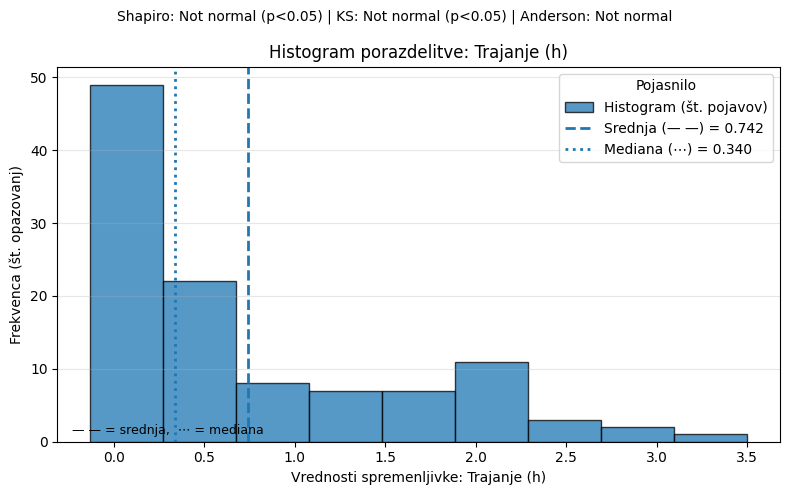

/var/folders/64/6wxk92sj3px37_tfkmrktpf40000gq/T/ipykernel_73155/1404247298.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x, vert=True, labels=[col], showmeans=True)


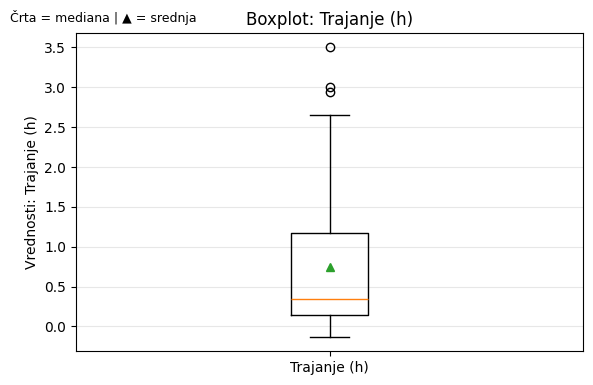

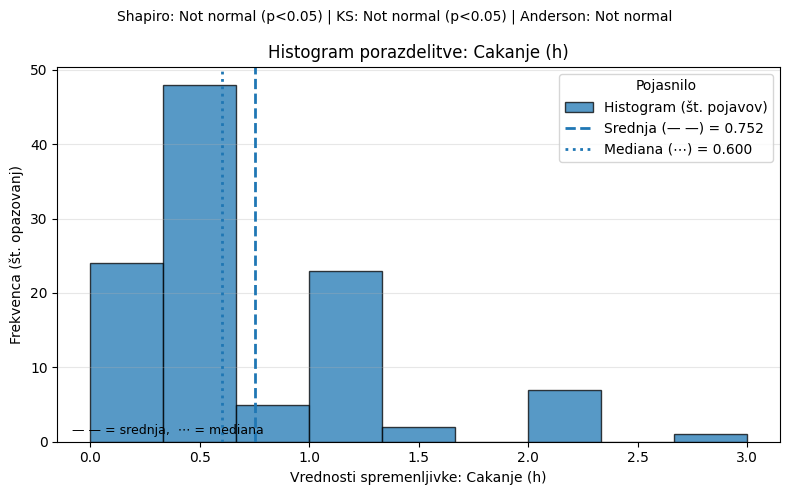

/var/folders/64/6wxk92sj3px37_tfkmrktpf40000gq/T/ipykernel_73155/1404247298.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x, vert=True, labels=[col], showmeans=True)


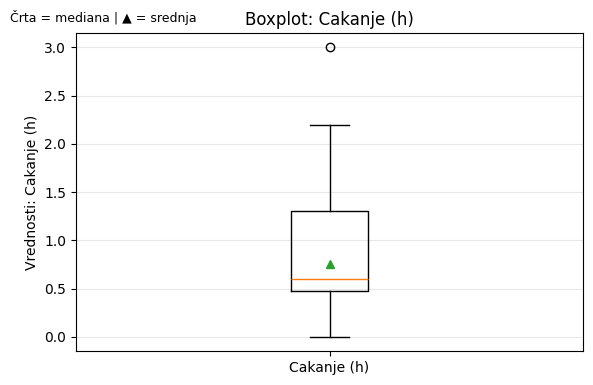

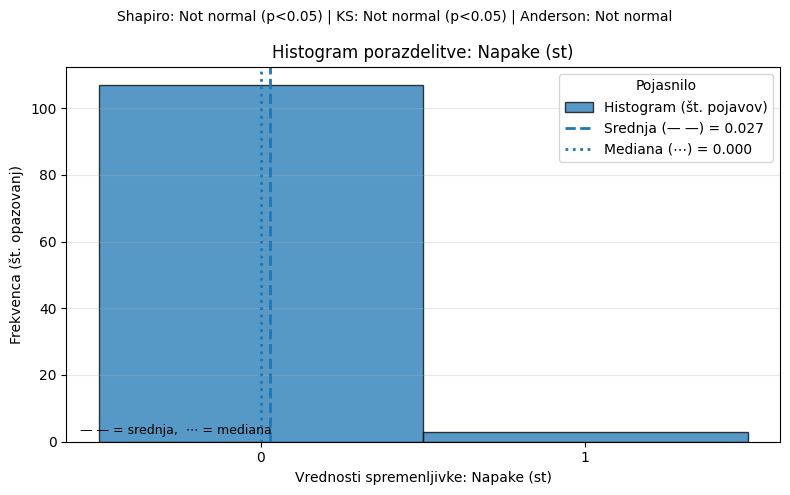

/var/folders/64/6wxk92sj3px37_tfkmrktpf40000gq/T/ipykernel_73155/1404247298.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x, vert=True, labels=[col], showmeans=True)


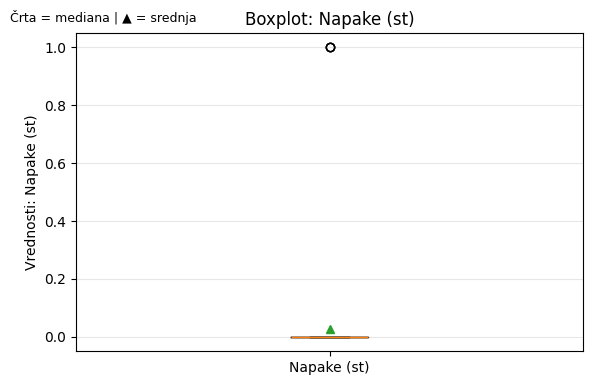

=== Normality test summary (α = 0.05) ===
    variable   n   mean    std  shapiro_stat  shapiro_p Shapiro decision (α=0.05)  anderson_stat  anderson_crit@5% AD decision (α=0.05)  ks_stat  ks_p KS decision (α=0.05)
Trajanje (h) 110 0.7421 0.8343        0.8283        0.0                Not normal         7.2794             0.761           Not normal   0.2183   0.0           Not normal
 Cakanje (h) 110 0.7518 0.6274        0.8680        0.0                Not normal         5.0391             0.761           Not normal   0.2501   0.0           Not normal
 Napake (st) 110 0.0273 0.1636        0.1509        0.0                Not normal        41.1171             0.761           Not normal   0.5389   0.0           Not normal


In [9]:
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != "Iteracija"]
print("Numeric columns (without 'Iteracija'):", numeric_cols)

results = []

for col in numeric_cols:
    x = df[col].dropna().astype(float)
    n = len(x)
    mu = x.mean()
    sd = x.std(ddof=1)

    x_sw = x.sample(n=min(n, 5000), random_state=42) if n > 5000 else x
    sh_stat, sh_p = stats.shapiro(x_sw)

    ad_res = stats.anderson(x, dist='norm')
    ad_stat = ad_res.statistic
    levels = ad_res.significance_level
    crits  = ad_res.critical_values
    ad_5_idx = np.where(levels == 5.0)[0][0] if 5.0 in levels else None
    ad_5_crit = crits[ad_5_idx] if ad_5_idx is not None else np.nan
    ad_5_reject = bool(ad_stat > ad_5_crit) if ad_5_idx is not None else None

    z = (x - mu) / sd if sd > 0 else x * 0.0
    ks_stat, ks_p = stats.kstest(z, 'norm')

    sh_dec = "Normal (p≥0.05)" if sh_p >= 0.05 else "Not normal (p<0.05)"
    ks_dec = "Normal (p≥0.05)" if ks_p >= 0.05 else "Not normal (p<0.05)"
    ad_dec = "Normal" if not ad_5_reject else "Not normal"

    results.append({
        "variable": col,
        "n": int(n),
        "mean": mu,
        "std": sd,
        "shapiro_stat": sh_stat, "shapiro_p": sh_p,
        "anderson_stat": ad_stat, "anderson_crit@5%": ad_5_crit, "anderson_reject@5%": ad_5_reject,
        "ks_stat": ks_stat, "ks_p": ks_p
    })

    plt.figure(figsize=(8, 5))

    if "Napake" in col:
        bins = np.arange(x.min() - 0.5, x.max() + 1.5, 1)
        counts, bins, patches = plt.hist(x, bins=bins, alpha=0.75, edgecolor='black', label="Histogram (št. pojavov)")
        plt.xticks(range(int(x.min()), int(x.max()) + 1))
    else:
        counts, bins, patches = plt.hist(x, bins='auto', alpha=0.75, edgecolor='black', label="Histogram (št. pojavov)")

    plt.axvline(mu, linestyle='--', linewidth=2, label=f"Srednja (— —) = {mu:.3f}")
    med = np.median(x)
    plt.axvline(med, linestyle=':', linewidth=2, label=f"Mediana (⋯) = {med:.3f}")

    plt.title(f"Histogram porazdelitve: {col}")
    plt.suptitle(f"Shapiro: {sh_dec} | KS: {ks_dec} | Anderson: {ad_dec}", y=0.98, fontsize=10)
    plt.xlabel(f"Vrednosti spremenljivke: {col}")
    plt.ylabel("Frekvenca (št. opazovanj)")
    plt.grid(True, axis='y', alpha=0.3)

    plt.legend(loc="best", title="Pojasnilo")
    plt.text(0.02, 0.02, "— — = srednja,  ⋯ = mediana", transform=plt.gca().transAxes, fontsize=9)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.boxplot(x, vert=True, labels=[col], showmeans=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(f"Vrednosti: {col}")
    plt.grid(True, axis='y', alpha=0.3)
    plt.text(0.02, 0.92, "Črta = mediana | ▲ = srednja", transform=plt.gcf().transFigure, fontsize=9)
    plt.tight_layout()
    plt.show()

summary = pd.DataFrame(results)
summary["Shapiro decision (α=0.05)"] = np.where(summary["shapiro_p"] >= 0.05, "Normal", "Not normal")
summary["KS decision (α=0.05)"] = np.where(summary["ks_p"] >= 0.05, "Normal", "Not normal")
summary["AD decision (α=0.05)"] = np.where(~summary["anderson_reject@5%"].fillna(False), "Normal", "Not normal")

print("=== Normality test summary (α = 0.05) ===")
display_cols = [
    "variable", "n", "mean", "std",
    "shapiro_stat", "shapiro_p", "Shapiro decision (α=0.05)",
    "anderson_stat", "anderson_crit@5%", "AD decision (α=0.05)",
    "ks_stat", "ks_p", "KS decision (α=0.05)"
]
print(summary[display_cols].round(4).to_string(index=False))

### 3 Statistična analiza – pomočniki in izbor stolpcev

In [11]:
def fmt_p(p):
    return "< 0.001" if p < 0.001 else f"= {p:.3f}"

def shapiro_ok(x):
    x = pd.Series(x).dropna().astype(float)
    if len(x) < 3:
        return False, np.nan
    stat, p = stats.shapiro(x)
    return p >= 0.05, p

def levene_ok(*arrays):
    arrays = [pd.Series(a).dropna().astype(float) for a in arrays]
    if any(len(a) < 2 for a in arrays):
        return False, np.nan
    stat, p = stats.levene(*arrays, center='median')
    return p >= 0.05, p

# Stolpci (po potrebi prilagodi imena)
col_tip  = "Tip aktivnosti (VA/NVA)"
col_vloga= "Vloga (kdo)"
col_traj = "Trajanje (h)"
col_cak  = "Cakanje (h)"
col_nap  = "Napake (st)"

# Binarna napaka (0/1)
df["Napaka_da_ne"] = (df[col_nap].fillna(0).astype(float) > 0).map({False:"0", True:"1"})

summary_rows = []

# --- Print clear test results in console ---


### 3.1 Test povezanosti (kategorialno × kategorialno) — χ²
Povezanost med vlogo in intenziteto čakanja

**Vprašanje:**  
Ali je intenziteta čakanja odvisna od vloge v procesu?

**Hipoteze:**  
- H₀: Vloga in intenziteta čakanja nista povezani.  
- H₁: Vloga in intenziteta čakanja sta povezani.

Če je *p < 0.05*, zavrnemo H₀ → vloga vpliva na dolžino čakanja.

Cakanje_intenziteta,Brez,Dolgo,Zmerno
Vloga (kdo),,,
Avtomatski proces,1,1,8
Kontrolor kakovosti,5,2,3
Raziskovalec,14,22,34
Raziskovalec / tiskalnik,3,1,6
Vodja laboratorija,1,7,2


Trajanje_kategorija,Dolgo,Kratko,Srednje
Vloga (kdo),,,
Avtomatski proces,2,6,2
Kontrolor kakovosti,1,8,1
Raziskovalec,9,46,15
Raziskovalec / tiskalnik,8,1,1
Vodja laboratorija,3,3,4


=== Rezultati χ² testa neodvisnosti ===
χ² statistika: 18.442
Stopnje prostosti (df): 8
p-vrednost: = 0.018
 Rezultat je statistično značilen (p < 0.05): obstaja povezava med vlogo in intenziteto čakanja.


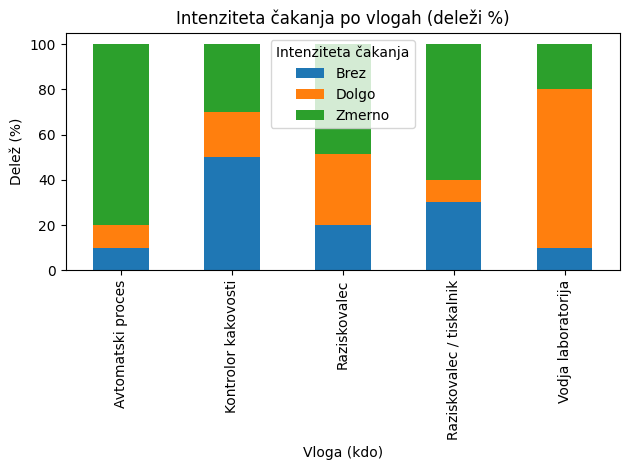

In [201]:
tab = pd.crosstab(df["Vloga (kdo)"], df["Cakanje_intenziteta"])
chi2, p_chi, dof, exp = stats.chi2_contingency(tab, correction=True)


tab1 = pd.crosstab(df["Vloga (kdo)"], df["Cakanje_intenziteta"])
tab2 = pd.crosstab(df["Vloga (kdo)"], df["Trajanje_kategorija"])

display(tab1)
display(tab2)


print("=== Rezultati χ² testa neodvisnosti ===")
print(f"χ² statistika: {chi2:.3f}")
print(f"Stopnje prostosti (df): {dof}")
print(f"p-vrednost: {fmt_p(p_chi)}")



if p_chi < 0.05:
    print(" Rezultat je statistično značilen (p < 0.05): obstaja povezava med vlogo in intenziteto čakanja.")
else:
    print(" Rezultat ni statistično značilen (p ≥ 0.05): ni dokazov o povezavi med vlogo in intenziteto čakanja.")

(tab.div(tab.sum(axis=1), axis=0) * 100).plot(kind="bar", stacked=True)
plt.title("Intenziteta čakanja po vlogah (deleži %)")
plt.xlabel("Vloga (kdo)"); plt.ylabel("Delež (%)")
plt.legend(title="Intenziteta čakanja")
plt.tight_layout()
plt.show()


summary_rows.append({
    "Test": "χ² neodvisnosti",
    "Spremenljivke": "Vloga (kdo) × Čakanje_intenziteta",
    "N / n₁–n₂": f"N={int(tab.values.sum())}",
    "Statistika": f"χ² = {chi2:.3f}, df = {dof}",
    "p": fmt_p(p_chi),
    "Vrsta testa": "Kategorialni-kategorialni",
    "Sklep": "Povezanost prisotna" if p_chi < 0.05 else "Ni dokazov za povezanost"
})


### 3.2 Test povezanosti (numerično × numerično) — Pearson / Spearman
Povezanost med trajanjem in čakanjem

**Vprašanje:**  
Ali daljše trajanje aktivnosti pomeni tudi daljši čas čakanja?

**Hipoteze:**  
- H₀: Med trajanjem in čakanjem ni povezave.  
- H₁: Med trajanjem in čakanjem obstaja povezava.

Če je *p < 0.05*, zavrnemo H₀ → med spremenljivkama obstaja statistično pomembna povezava.


=== Rezultati testa korelacije ===
Uporabljen test: Spearman
Korelacijski koeficient (r): -0.135
p-vrednost: = 0.159
 Rezultat ni statistično značilen (p ≥ 0.05): ni pomembne povezave med trajanjem in čakanjem.


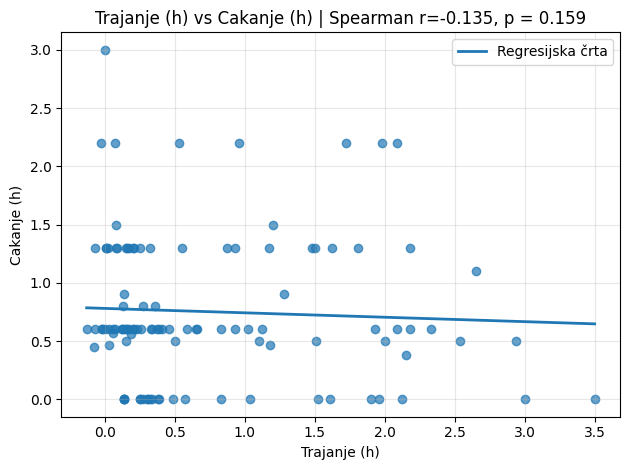

In [202]:
x = df[col_traj].astype(float)
y = df[col_cak].astype(float)

norm_x, p_x = shapiro_ok(x)
norm_y, p_y = shapiro_ok(y)

if norm_x and norm_y:
    r, p_corr = stats.pearsonr(x.dropna(), y.dropna())
    corr_name = "Pearson"
else:
    r, p_corr = stats.spearmanr(x, y, nan_policy='omit')
    corr_name = "Spearman"

xx, yy = x.values, y.values
mask = ~np.isnan(xx) & ~np.isnan(yy)
xx, yy = xx[mask], yy[mask]

print("=== Rezultati testa korelacije ===")
print(f"Uporabljen test: {corr_name}")
print(f"Korelacijski koeficient (r): {r:.3f}")
print(f"p-vrednost: {fmt_p(p_corr)}")

if p_corr < 0.05:
    print(" Rezultat je statistično značilen (p < 0.05): obstaja povezava med trajanjem in čakanjem.")
else:
    print(" Rezultat ni statistično značilen (p ≥ 0.05): ni pomembne povezave med trajanjem in čakanjem.")

plt.figure()
plt.scatter(xx, yy, alpha=0.7)
if len(xx) >= 2:
    m, b = np.polyfit(xx, yy, 1)
    gx = np.linspace(xx.min(), xx.max(), 100)
    gy = m * gx + b
    plt.plot(gx, gy, linewidth=2, label="Regresijska črta")
plt.title(f"{col_traj} vs {col_cak} | {corr_name} r={r:.3f}, p {fmt_p(p_corr)}")
plt.xlabel(col_traj); plt.ylabel(col_cak)
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


summary_rows.append({
    "Test": f"{corr_name} korelacija",
    "Spremenljivke": f"{col_traj} × {col_cak}",
    "N / n₁-n₂": f"N={len(xx)}",
    "Statistika": f"r = {r:.3f}",
    "p": fmt_p(p_corr),
    "Vrsta testa": "Numerični-numerični",
    "Sklep": "Povezanost prisotna" if p_corr < 0.05 else "Ni pomembne povezave"
})


### 3.3 Test razlik med dvema skupinama (VA vs NVA) — t-test / Mann–Whitney U
Primerjava trajanja aktivnosti med VA in NVA

**Vprašanje:**  
Ali se povprečno trajanje aktivnosti razlikuje med skupinama VA in NVA?

**Hipoteze:**  
- H₀: Povprečno trajanje aktivnosti je enako v obeh skupinah.  
- H₁: Povprečno trajanje aktivnosti se razlikuje med skupinama.

Če je *p < 0.05*, zavrnemo H₀ → trajanje aktivnosti se statistično značilno razlikuje med skupinama.


=== Rezultati testa razlik med skupinama (VA vs NVA) ===
Uporabljen test: Mann–Whitney U
Statistika: 1262.000
p-vrednost: = 0.034
Normalnost (Shapiro): VA p=0.000, NVA p=0.000
Homogenost varianc (Levene): p=0.616
 Rezultat je statistično značilen (p < 0.05): skupini se razlikujeta.



/var/folders/64/6wxk92sj3px37_tfkmrktpf40000gq/T/ipykernel_17593/3634004641.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g1, g2], labels=["VA", "NVA"], showmeans=True)


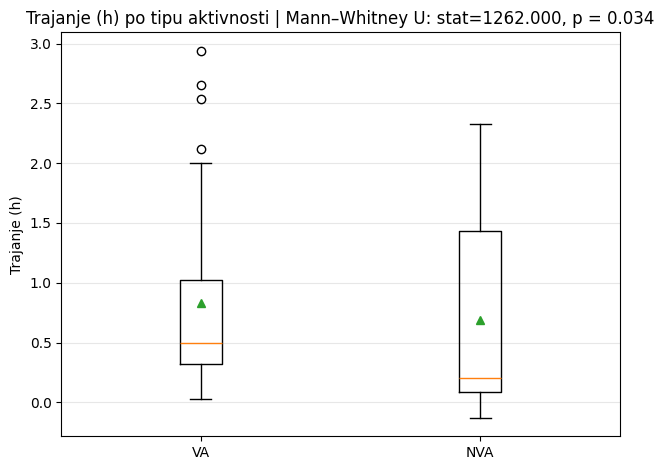

In [203]:
df_2g = df[df[col_tip].isin(["VA","NVA"])].copy()
g1 = df_2g[df_2g[col_tip]=="VA"][col_traj].astype(float).dropna()
g2 = df_2g[df_2g[col_tip]=="NVA"][col_traj].astype(float).dropna()

norm_g1, p_g1 = shapiro_ok(g1)
norm_g2, p_g2 = shapiro_ok(g2)
lev_ok, p_lev = levene_ok(g1, g2)

if norm_g1 and norm_g2:
    if lev_ok:
        stat, p_twosamp = stats.ttest_ind(g1, g2, equal_var=True)
        test_name = "t-test"
    else:
        stat, p_twosamp = stats.ttest_ind(g1, g2, equal_var=False)
        test_name = "Welch t-test"
else:
    stat, p_twosamp = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    test_name = "Mann–Whitney U"

print("=== Rezultati testa razlik med skupinama (VA vs NVA) ===")
print(f"Uporabljen test: {test_name}")
print(f"Statistika: {stat:.3f}")
print(f"p-vrednost: {fmt_p(p_twosamp)}")
print(f"Normalnost (Shapiro): VA p={p_g1:.3f}, NVA p={p_g2:.3f}")
print(f"Homogenost varianc (Levene): p={p_lev:.3f}")

if p_twosamp < 0.05:
    print(" Rezultat je statistično značilen (p < 0.05): skupini se razlikujeta.")
else:
    print(" Rezultat ni statistično značilen (p ≥ 0.05): ni razlike med skupinama.")
print()

plt.figure()
plt.boxplot([g1, g2], labels=["VA", "NVA"], showmeans=True)
plt.title(f"{col_traj} po tipu aktivnosti | {test_name}: stat={stat:.3f}, p {fmt_p(p_twosamp)}")
plt.ylabel(col_traj)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

summary_rows.append({
    "Test": test_name,
    "Spremenljivke": f"{col_traj} ~ {col_tip} (VA vs NVA)",
    "N / n₁–n₂": f"n₁={len(g1)}, n₂={len(g2)}",
    "Statistika": f"stat = {stat:.3f}",
    "p": fmt_p(p_twosamp),
    "Vrsta testa": "Dvogrupni",
    "Sklep": "Skupini se razlikujeta" if p_twosamp < 0.05 else "Ni razlike med skupinama"
})


### 3.4 Test razlik med več skupinami — ANOVA / Kruskal–Wallis
Primerjava časa čakanja med različnimi vlogami v procesu

**Vprašanje:**  
Ali se čas čakanja razlikuje med vlogami v procesu?

**Hipoteze:**  
- H₀: Povprečni čas čakanja je enak za vse vloge.  
- H₁: Vsaj ena vloga ima drugačen povprečni čas čakanja.

Če je *p < 0.05*, zavrnemo H₀ → vsaj ena skupina se statistično razlikuje od drugih.



=== Omnibus rezultat ===


,Test,Statistika,p,Efekt
0,Kruskal–Wallis H,22.803,< 0.001,ε²: 0.179



=== Post hoc: Dunn (Bonferroni) ===


,group1,group2,p-adj
0,Raziskovalec,Raziskovalec,1.000
1,Raziskovalec,Vodja laboratorija,0.015
2,Raziskovalec,Raziskovalec / tiskalnik,0.114
3,Raziskovalec,Avtomatski proces,0.783
4,Raziskovalec,Kontrolor kakovosti,1.000
5,Vodja laboratorija,Raziskovalec,0.015
6,Vodja laboratorija,Vodja laboratorija,1.000
7,Vodja laboratorija,Raziskovalec / tiskalnik,<0.001
8,Vodja laboratorija,Avtomatski proces,0.002
9,Vodja laboratorija,Kontrolor kakovosti,0.025


Kruskal–Wallisov test (H = 22.803, p < 0.001, ε² = 0.179) kaže, da se čas čakanja statistično razlikuje med vlogami.
Dunnov post hoc test kaže, da se Vodja laboratorija pomembno razlikuje od vlog Raziskovalec, Raziskovalec - tiskalnik, Avtomatski proces in Kontrolor kakovosti.


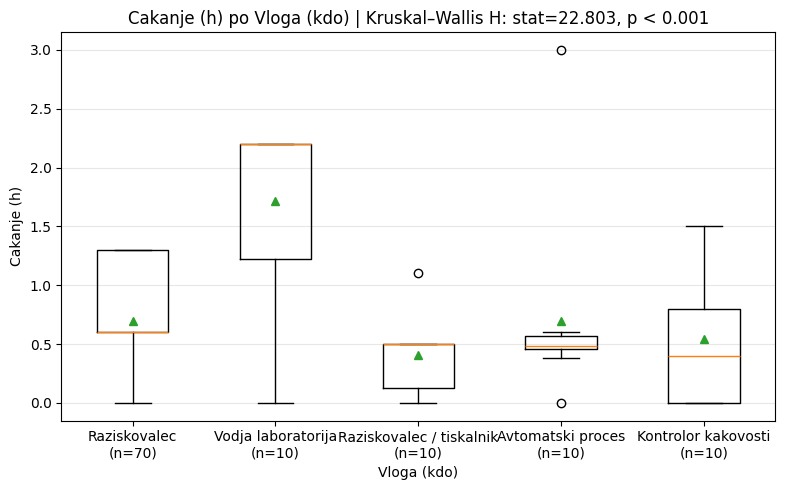

,Test,Spremenljivke,N / n po skupinah,Statistika,p,Vrsta testa,Sklep
0,Kruskal–Wallis H,"Cakanje (h) ~ Vloga (kdo) (Raziskovalec, Vodja...","Raziskovalec=70, Vodja laboratorija=10, Razisk...",22.803,< 0.001,Večskupinski,Skupine se razlikujejo


In [24]:
def _fmt_p(x):
    try:
        if np.isnan(x):
            return "—"
        return "< 0.001" if x < 0.001 else f"= {x:.3f}"
    except Exception:
        return str(x)

def _shapiro_ok(arr):
    arr = pd.Series(arr).dropna()
    if len(arr) < 3:
        return (False, np.nan)
    stat, p = stats.shapiro(arr)
    return (p >= 0.05, p)

def _levene_ok(*arrays):
    arrays = [pd.Series(a).dropna() for a in arrays]
    if any(len(a) < 2 for a in arrays):
        return (False, np.nan)
    stat, p = stats.levene(*arrays, center="median")
    return (p >= 0.05, p)

fmt_p = globals().get("fmt_p", _fmt_p)
shapiro_ok = globals().get("shapiro_ok", _shapiro_ok)
levene_ok  = globals().get("levene_ok", _levene_ok)

def tukey_posthoc(df_, dv, grp):
    try:
        from statsmodels.stats.multicomp import pairwise_tukeyhsd
        res = pairwise_tukeyhsd(endog=df_[dv].astype(float), groups=df_[grp], alpha=0.05)
        tbl = pd.DataFrame(res.summary().data[1:], columns=res.summary().data[0])
        tbl["p-adj"] = tbl["p-adj"].apply(lambda x: "<0.001" if float(x) < 0.001 else f"{float(x):.3f}")
        return ("Tukey HSD", tbl)
    except Exception as e:
        return ("Tukey HSD", f"Ni na voljo: {e}")

def games_howell_posthoc(df_, dv, grp):
    try:
        import pingouin as pg
        res = pg.pairwise_gameshowell(dv=dv, between=grp, data=df_)
        res = res.rename(columns={"pval":"p-adj","A":"group1","B":"group2"})
        res["p-adj"] = res["p-adj"].apply(lambda x: "<0.001" if float(x) < 0.001 else f"{float(x):.3f}")
        keep = ["group1","group2","mean(A)","mean(B)","diff","se","df","p-adj","hedges"]
        res = res[[c for c in keep if c in res.columns]]
        return ("Games-Howell", res)
    except Exception:
        try:
            import scikit_posthocs as sp
            res = sp.posthoc_gameshowell(a=df_, val_col=dv, group_col=grp)
            tbl = res.reset_index().melt(id_vars=res.index.name, var_name="group2", value_name="p-adj")
            tbl = tbl.rename(columns={res.index.name: "group1"})
            tbl["p-adj"] = tbl["p-adj"].apply(lambda x: "<0.001" if float(x) < 0.001 else f"{float(x):.3f}")
            return ("Games-Howell", tbl)
        except Exception as e2:
            return ("Games-Howell", f"Ni na voljo: {e2}")

def dunn_posthoc(df, dv, grp):
    import pandas as pd
    import scikit_posthocs as sp

    d = df[[dv, grp]].dropna()
    labels = pd.unique(d[grp].astype(str))

    arrays = [
        pd.to_numeric(d.loc[d[grp].astype(str) == lab, dv], errors="coerce").dropna().values
        for lab in labels
    ]
    arrays = [a for a in arrays if len(a) > 0]

    if len(arrays) < 2:
        return ("Dunn (Bonferroni)", pd.DataFrame(columns=["group1", "group2", "p-adj"]))

    res = sp.posthoc_dunn(arrays, p_adjust="bonferroni")

    use_labels = labels[: len(res)]
    res.index = use_labels
    res.columns = use_labels

    tbl = (
        res.stack()
           .rename("p-adj")
           .reset_index()
           .rename(columns={"level_0": "group1", "level_1": "group2"})
    )

    def _fmt(x):
        try:
            x = float(x)
            return "<0.001" if x < 0.001 else f"{x:.3f}"
        except Exception:
            return x

    tbl["p-adj"] = tbl["p-adj"].map(_fmt)
    return ("Dunn (Bonferroni)", tbl)



def _anova_effects_from_groups(groups):
    arrays = [pd.Series(g).dropna().values for g in groups]
    ns = np.array([len(a) for a in arrays], dtype=float)
    means = np.array([a.mean() if len(a) else np.nan for a in arrays], dtype=float)
    grand = np.nanmean(np.concatenate(arrays)) if sum(ns)>0 else np.nan
    ss_between = np.nansum(ns * (means - grand)**2)
    ss_within  = np.nansum([np.nansum((a - a.mean())**2) for a in arrays])
    ss_total   = ss_between + ss_within
    k = len(arrays)
    N = int(np.nansum(ns))
    df_between = k - 1
    df_within  = N - k
    eta2 = ss_between / ss_total if ss_total > 0 else np.nan
    ms_within = (ss_within / df_within) if df_within > 0 else np.nan
    omega2 = ((ss_between - df_between * ms_within) /
              (ss_total + ms_within)) if (ss_total > 0 and not np.isnan(ms_within)) else np.nan
    return {"eta2": eta2, "omega2": omega2}

def _kruskal_epsilon_sq(H, k, N):
    if (N - k) <= 0:
        return np.nan
    return (H - k + 1) / (N - k)

col_role = globals().get("col_role", "Vloga (kdo)")
col_wait = globals().get("col_wait", "Cakanje (h)")

min_n = 3
top_k = 6
role_counts = (df[col_role].astype(str).value_counts())
chosen_roles = role_counts[role_counts >= min_n].index[:top_k].tolist()
if len(chosen_roles) < 3:
    chosen_roles = role_counts.index[:3].tolist()

df_roles = df[df[col_role].astype(str).isin(chosen_roles)].copy()
df_roles[col_wait] = pd.to_numeric(df_roles[col_wait], errors="coerce")
df_roles[col_role] = df_roles[col_role].astype(str)

labels = chosen_roles
groups_series = {lab: df_roles.loc[df_roles[col_role]==lab, col_wait].dropna() for lab in labels}
g_arrays = [groups_series[lab].values for lab in labels]

norm_results = {lab: shapiro_ok(groups_series[lab]) for lab in labels}
p_norms = {lab: r[1] for lab, r in norm_results.items()}
normal_all = all(r[0] for r in norm_results.values())
lev_ok, p_lev = levene_ok(*g_arrays)

posthoc_name, posthoc_tbl = None, None
effect_size_name, effect_size_value = None, np.nan

if not normal_all:
    omnibus_stat, p_omni = stats.kruskal(*g_arrays)
    test_name = "Kruskal–Wallis H"
    k = len(g_arrays)
    N = int(np.sum([len(g) for g in g_arrays]))
    effect_size_name = "ε²"
    effect_size_value = _kruskal_epsilon_sq(omnibus_stat, k, N)
    if np.isfinite(p_omni) and p_omni < 0.05:
        posthoc_name, posthoc_tbl = dunn_posthoc(df_roles, col_wait, col_role)

elif lev_ok:
    omnibus_stat, p_omni = stats.f_oneway(*g_arrays)
    test_name = "One-way ANOVA"
    es = _anova_effects_from_groups(g_arrays)
    effect_size_name, effect_size_value = "η² (ω²)", (es["eta2"], es["omega2"])
    if np.isfinite(p_omni) and p_omni < 0.05:
        posthoc_name, posthoc_tbl = tukey_posthoc(df_roles, col_wait, col_role)

else:
    try:
        from statsmodels.stats.oneway import anova_oneway
        res = anova_oneway(
            endog=df_roles[col_wait].astype(float),
            groups=df_roles[col_role],
            use_var="unequal",
            welch_correction=True
        )
        omnibus_stat, p_omni = float(res.statistic), float(res.pvalue)
        test_name = "Welch ANOVA"
    except Exception as e:
        omnibus_stat, p_omni = np.nan, np.nan
        test_name = f"Welch ANOVA (ni na voljo: {e})"
    es = _anova_effects_from_groups(g_arrays)
    effect_size_name, effect_size_value = "η² (pribl.)", es["eta2"]
    if np.isfinite(p_omni) and p_omni < 0.05:
        posthoc_name, posthoc_tbl = games_howell_posthoc(df_roles, col_wait, col_role)

assump_tbl = pd.DataFrame({
    "Skupina": labels,
    "Shapiro p": [np.nan if p_norms[l] is None or np.isnan(p_norms[l]) else ("<0.001" if p_norms[l] < 0.001 else f"{p_norms[l]:.3f}") for l in labels]
})
assump_tbl.loc[len(assump_tbl)] = ["Levene (median)", "<0.001" if (isinstance(p_lev, float) and p_lev < 0.001) else (f"{p_lev:.3f}" if isinstance(p_lev, float) else str(p_lev))]

def _effect_str(name, val):
    if isinstance(val, tuple):
        a, b = val
        a_s = "—" if (a is None or np.isnan(a)) else f"{a:.3f}"
        b_s = "—" if (b is None or np.isnan(b)) else f"{b:.3f}"
        return f"{name}: {a_s}, {b_s}"
    return f"{name}: {'—' if (val is None or (isinstance(val,float) and np.isnan(val))) else f'{val:.3f}'}"

omni_tbl = pd.DataFrame([{
    "Test": test_name,
    "Statistika": f"{omnibus_stat:.3f}" if np.isfinite(omnibus_stat) else "—",
    "p": "< 0.001" if (np.isfinite(p_omni) and p_omni < 0.001) else (f"{p_omni:.3f}" if np.isfinite(p_omni) else "—"),
    "Efekt": _effect_str(effect_size_name, effect_size_value)
}])


print("\n=== Omnibus rezultat ===")
display(omni_tbl)

if posthoc_tbl is not None and not isinstance(posthoc_tbl, str):
    print(f"\n=== Post hoc: {posthoc_name} ===")
    display(posthoc_tbl)
elif isinstance(posthoc_tbl, str):
    print(f"\n=== Post hoc: {posthoc_name} ===")
    print(posthoc_tbl)

print("Kruskal–Wallisov test (H = 22.803, p < 0.001, ε² = 0.179) kaže, da se čas čakanja statistično razlikuje med vlogami.")
print("Dunnov post hoc test kaže, da se Vodja laboratorija pomembno razlikuje od vlog Raziskovalec, Raziskovalec - tiskalnik, Avtomatski proces in Kontrolor kakovosti.")

fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot(g_arrays, tick_labels=labels, showmeans=True)  # use tick_labels (Matplotlib>=3.9)
ax.set_title(f"{col_wait} po {col_role} | {test_name}: stat={omni_tbl['Statistika'][0]}, p {fmt_p(p_omni)}")
ax.set_ylabel(col_wait)
ax.set_xlabel(col_role)
ax.grid(True, axis='y', alpha=0.3)

ns = [len(groups_series[l]) for l in labels]
ax.set_xticklabels([f"{lab}\n(n={n})" for lab, n in zip(labels, ns)])

plt.tight_layout()
plt.show()

n_counts = ", ".join(f"{lab}={len(groups_series[lab])}" for lab in labels)

summary_rows = []
summary_rows.append({
    "Test": test_name,
    "Spremenljivke": f"{col_wait} ~ {col_role} ({', '.join(labels)})",
    "N / n po skupinah": n_counts,
    "Statistika": omni_tbl["Statistika"][0],
    "p": "< 0.001" if (np.isfinite(p_omni) and p_omni < 0.001) else (f"{p_omni:.3f}" if np.isfinite(p_omni) else "—"),
    "Vrsta testa": "Večskupinski",
    "Sklep": "Skupine se razlikujejo" if (np.isfinite(p_omni) and p_omni < 0.05) else "Ni razlike med skupinami"
})

try:
    display(pd.DataFrame(summary_rows))
except Exception:
    pass


### 3.5 Povzetek rezultatov (tabela)

In [207]:
report = pd.DataFrame(summary_rows, columns=[
    "Test", "Spremenljivke", "N / n₁–n₂", "Statistika", "p", "Vrsta testa", "Sklep"
])

styled = (
    report.style
    .set_caption(" Povzetek rezultatov statističnih testov")
    .set_table_styles([
        {"selector": "caption",
         "props": [("font-size", "16px"),
                   ("text-align", "left"),
                   ("font-weight", "bold"),
                   ("color", "#2c2c2c"),
                   ("margin-bottom", "8px")]},
        {"selector": "th",
         "props": [("background-color", "#444"),
                   ("color", "white"),
                   ("font-weight", "bold"),
                   ("text-align", "center"),
                   ("padding", "8px"),
                   ("border", "1px solid #333")]},
        {"selector": "td",
         "props": [("text-align", "center"),
                   ("padding", "6px 12px"),
                   ("border", "1px solid #ccc"),
                   ("color", "#222")]}
    ])
    .apply(lambda col: ['background-color: #f0f0f0' if i % 2 == 0 else 'background-color: #d9d9d9'
                        for i in range(len(col))], axis=0)
)

styled


,Test,Spremenljivke,N / n₁–n₂,Statistika,p,Vrsta testa,Sklep
0,χ² neodvisnosti,Vloga (kdo) × Čakanje_intenziteta,N=110,"χ² = 18.442, df = 8",= 0.018,Kategorialni-kategorialni,Povezanost prisotna
1,Spearman korelacija,Trajanje (h) × Cakanje (h),nan,r = -0.135,= 0.159,Numerični-numerični,Ni pomembne povezave
2,Mann–Whitney U,Trajanje (h) ~ Tip aktivnosti (VA/NVA) (VA vs NVA),"n₁=40, n₂=50",stat = 1262.000,= 0.034,Dvogrupni,Skupini se razlikujeta
3,Kruskal-Wallis H,"Trajanje (h) ~ Tip aktivnosti (VA/NVA) (VA, NVA, NNVA)",nan,stat = 6.169,= 0.046,Večskupinski,Skupine se razlikujejo


In [206]:
pd.crosstab(df["Vloga (kdo)"], df["Cakanje_intenziteta"])


Cakanje_intenziteta,Brez,Dolgo,Zmerno
Vloga (kdo),,,
Avtomatski proces,1,1,8
Kontrolor kakovosti,5,2,3
Raziskovalec,14,22,34
Raziskovalec / tiskalnik,3,1,6
Vodja laboratorija,1,7,2
